# Swing Trading

### Strategy 1
1. Today is Monday.
2. Today’s close is lower than Friday’s.
3. Friday’s close was lower than Thursday’s close.
4. If 1-3 are true, then buy at the close.
5. Exit at the close next Monday or Tuesday if Monday is a holiday.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Importing the dataset
data = pd.read_csv('./Candle_data/^NSEI-MAX.csv', index_col=0, parse_dates=True)
data = data.dropna()
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

print(data.head())
print('#' * 30)
print(data.tail())
print('#' * 30)
print(data.info())

                   Open         High          Low        Close  Volume
Date                                                                  
2007-09-17  4518.450195  4549.049805  4482.850098  4494.649902     0.0
2007-09-18  4494.100098  4551.799805  4481.549805  4546.200195     0.0
2007-09-19  4550.250000  4739.000000  4550.250000  4732.350098     0.0
2007-09-20  4734.850098  4760.850098  4721.149902  4747.549805     0.0
2007-09-21  4752.950195  4855.700195  4733.700195  4837.549805     0.0
##############################
                    Open          High           Low         Close    Volume
Date                                                                        
2023-12-04  20601.949219  20702.650391  20507.750000  20686.800781  381100.0
2023-12-05  20808.900391  20864.050781  20711.150391  20855.099609  421000.0
2023-12-06  20950.750000  20961.949219  20852.150391  20937.699219  359200.0
2023-12-07  20932.400391  20941.250000  20850.800781  20901.150391  275000.0
2023-12-08

In [3]:
df = data.copy()
df['Date'] = df.index

# Assuming you have a DataFrame named 'df' with columns: 'Date', 'Open', 'High', 'Low', 'Close'
# Make sure that the 'Date' column is in datetime format

# Add a column for the day of the week (Monday is 0, Sunday is 6)
df['day_of_week'] = df['Date'].dt.dayofweek

# Add columns for the previous close values
df['prev_close'] = df['Close'].shift(1)
df['prev_prev_close'] = df['Close'].shift(2)

# Create a column to store buy signals
df['buy_signal'] = np.where(
    (df['day_of_week'] == 0) &  # Monday
    (df['Close'] < df['prev_close']) &
    (df['prev_close'] < df['prev_prev_close']),
    df['Close'],
    np.nan
)

# Create a column to store exit signals
df['exit_signal'] = np.where(
    ((df['day_of_week'] == 0) | (df['day_of_week'] == 1)) &  # Monday or Tuesday
    (df['day_of_week'].shift(-1) == 2),  # Next day is Wednesday (assuming Monday is a holiday)
    df['Close'],
    np.nan
)

# Create a column to store positions (1 for long, 0 for no position)
df['position'] = np.where(df['buy_signal'].notnull(), 1, 0)
df['position'] = df['position'].ffill().fillna(0)

# Calculate daily returns
df['returns'] = df['Close'].pct_change()

# Calculate strategy returns
df['strategy_returns'] = df['position'].shift(1) * df['returns']

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()
df['cumulative_strategy_returns'] = (1 + df['strategy_returns']).cumprod()

# Display the DataFrame with relevant columns
print(df[['Date', 'Close', 'buy_signal', 'exit_signal', 'position', 'returns', 'strategy_returns', 'cumulative_returns', 'cumulative_strategy_returns']])


                 Date         Close  buy_signal   exit_signal  position  \
Date                                                                      
2007-09-17 2007-09-17   4494.649902         NaN           NaN         0   
2007-09-18 2007-09-18   4546.200195         NaN   4546.200195         0   
2007-09-19 2007-09-19   4732.350098         NaN           NaN         0   
2007-09-20 2007-09-20   4747.549805         NaN           NaN         0   
2007-09-21 2007-09-21   4837.549805         NaN           NaN         0   
...               ...           ...         ...           ...       ...   
2023-12-04 2023-12-04  20686.800781         NaN           NaN         0   
2023-12-05 2023-12-05  20855.099609         NaN  20855.099609         0   
2023-12-06 2023-12-06  20937.699219         NaN           NaN         0   
2023-12-07 2023-12-07  20901.150391         NaN           NaN         0   
2023-12-08 2023-12-08  20969.400391         NaN           NaN         0   

             returns  st

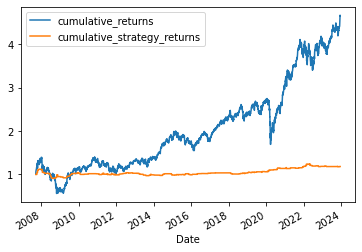

In [4]:
# Plot the cumulative returns
import matplotlib.pyplot as plt
df[['cumulative_returns', 'cumulative_strategy_returns']].plot()
plt.show()



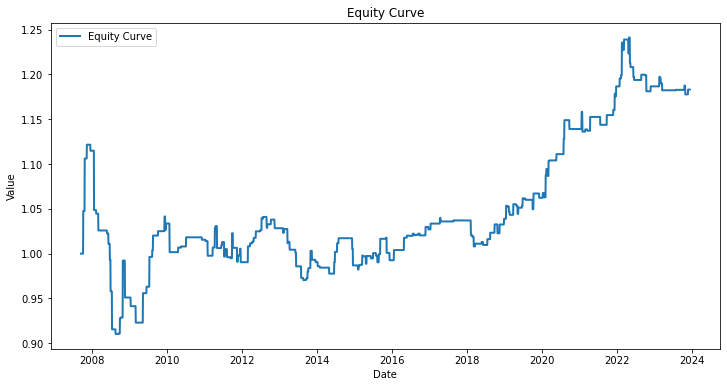

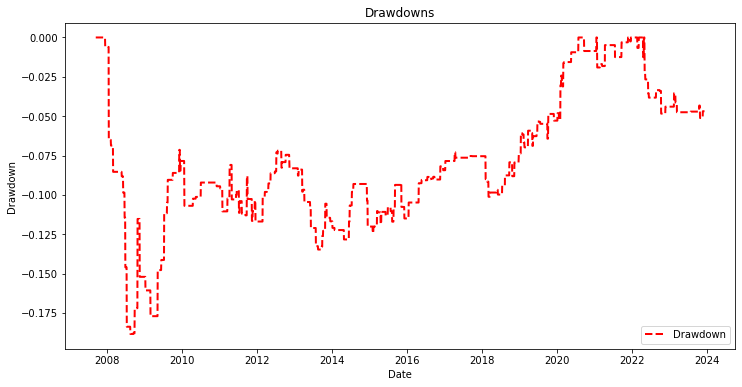

Max Drawdown: -18.84%
Max Drawdown Duration: 2008-08-19 00:00:00 to 2022-04-26 00:00:00
CAGR: 1.07%
CAGR (Buy and Hold): 10.25%
Annual Volatility: 5.06%
Sharpe Ratio: 0.24


In [5]:

# Calculate drawdown
df['roll_max'] = df['cumulative_strategy_returns'].cummax()
df['drawdown'] = df['cumulative_strategy_returns'] / df['roll_max'] - 1

# Calculate max drawdown
max_drawdown = df['drawdown'].min()

# Plot equity curve against buy and hold strategy
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cumulative_strategy_returns'], label='Equity Curve', linewidth=2)
# plt.plot(df['Date'], df['cumulative_returns'], label='Buy and Hold', linewidth=2)
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['drawdown'], label='Drawdown', color='red', linewidth=2, linestyle='--')
plt.title('Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

# Display max drawdown
print(f'Max Drawdown: {max_drawdown:.2%}')
print(f'Max Drawdown Duration: {df["drawdown"].idxmin()} to {df["roll_max"].idxmax()}')
print(f'CAGR: {df["cumulative_strategy_returns"].iloc[-1] ** (252 / len(df)) - 1:.2%}')
print(f'CAGR (Buy and Hold): {df["cumulative_returns"].iloc[-1] ** (252 / len(df)) - 1:.2%}')
print(f'Annual Volatility: {df["strategy_returns"].std() * np.sqrt(252):.2%}')
print(f'Sharpe Ratio: {df["strategy_returns"].mean() / df["strategy_returns"].std() * np.sqrt(252):.2f}')



### Strategy 2
1. Today’s close must be down for the third consecutive day.
2. If 1 is true, then enter at the close.
3. Exit at the open tomorrow (no matter what).

In [6]:
df = data.copy()
df['Date'] = df.index

### Strategy 2
# 1. Today’s close must be down for the third consecutive day.
# 2. If 1 is true, then enter at the close.
# 3. Exit at the open tomorrow (no matter what).

# Assuming you have a DataFrame named 'df' with columns: 'Date', 'Open', 'High', 'Low', 'Close'
# Make sure that the 'Date' column is in datetime format

# Add a column for the day of the week (Monday is 0, Sunday is 6)
df['day_of_week'] = df['Date'].dt.dayofweek

# Add columns for the previous close values
df['prev_close'] = df['Close'].shift(-1)
df['prev_prev_close'] = df['Close'].shift(-2)
df['prev_prev_prev_close'] = df['Close'].shift(-3)

# Create a column to store buy signals
df['buy_signal'] = np.where(
    (df['Close'] < df['prev_close']) &
    (df['prev_close'] < df['prev_prev_close']) &
    (df['prev_prev_close'] < df['prev_prev_prev_close']),
    df['Close'],
    np.nan
)

# Create a column to store exit signals, we sell next day at open no matter what, if there is a buy signal we sell at open the day after
df['exit_signal'] = np.where(
    df['buy_signal'].notnull(), # Buy signal
    df['Open'].shift(1),
    np.nan
)

# Create a column to store returns of every trade where we buy at the close and sell at the open the next day
df['returns'] = np.where(
    (df['buy_signal'].notnull()) & # Buy signal
    (df['exit_signal'].notnull()), # Exit signal
    (df['exit_signal'] - df['buy_signal']),
    np.nan
)

# Calculate strategy returns
df['strategy_returns'] = df['returns'] / df['Close']

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

# Calculate cumulative returns for buy and hold strategy
# df['cumulative_returns'] = (1 + df['returns'] / df['Close']).cumprod()

# Display the DataFrame with relevant columns
print(df[['Date', 'Close', 'buy_signal', 'exit_signal', 'returns', 'strategy_returns', 'cumulative_returns']])



                 Date         Close   buy_signal  exit_signal     returns  \
Date                                                                        
2007-09-17 2007-09-17   4494.649902  4494.649902          NaN         NaN   
2007-09-18 2007-09-18   4546.200195  4546.200195  4518.450195  -27.750000   
2007-09-19 2007-09-19   4732.350098  4732.350098  4494.100098 -238.250000   
2007-09-20 2007-09-20   4747.549805  4747.549805  4550.250000 -197.299805   
2007-09-21 2007-09-21   4837.549805  4837.549805  4734.850098 -102.699707   
...               ...           ...          ...          ...         ...   
2023-12-04 2023-12-04  20686.800781          NaN          NaN         NaN   
2023-12-05 2023-12-05  20855.099609          NaN          NaN         NaN   
2023-12-06 2023-12-06  20937.699219          NaN          NaN         NaN   
2023-12-07 2023-12-07  20901.150391          NaN          NaN         NaN   
2023-12-08 2023-12-08  20969.400391          NaN          NaN         NaN   

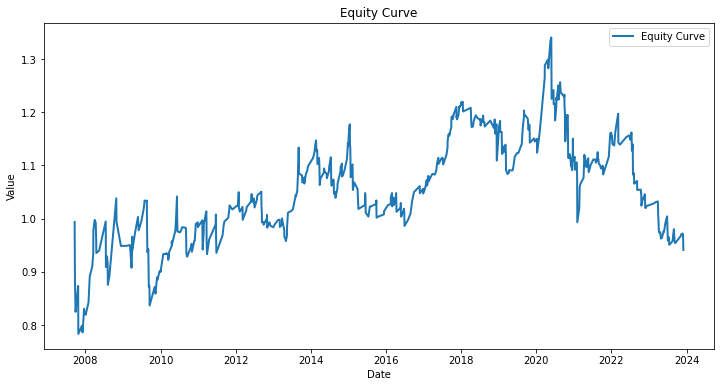

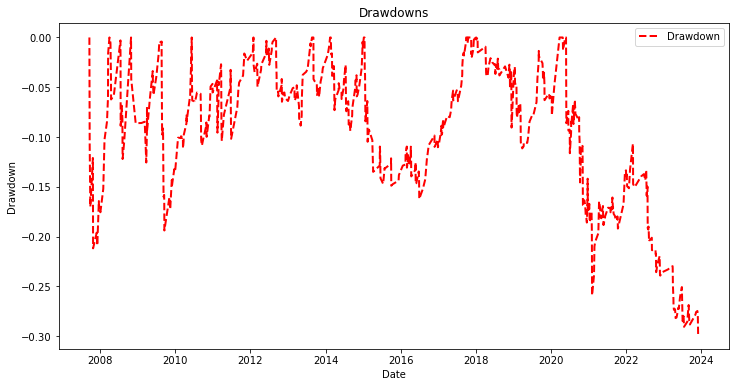

Max Drawdown: -29.78%
Max Drawdown Duration: 2023-12-01 00:00:00 to 2020-05-26 00:00:00
CAGR: -2.29%
Annual Volatility: 27.23%
Sharpe Ratio: 0.05


In [7]:
df = df.dropna(subset=['cumulative_returns'])
# Substituting NaN values with 0 for the purpose of calculating drawdowns in cumulative returns
# df = df.fillna(0)

# Plot the cumulative returns
import matplotlib.pyplot as plt

# Calculate drawdown
df['roll_max'] = df['cumulative_returns'].cummax()
df['drawdown'] = df['cumulative_returns'] / df['roll_max'] - 1

# Calculate max drawdown
max_drawdown = df['drawdown'].min()

# Plot equity curve against buy and hold strategy
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cumulative_returns'], label='Equity Curve', linewidth=2)
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['drawdown'], label='Drawdown', color='red', linewidth=2, linestyle='--')
plt.title('Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

# Display max drawdown
print(f'Max Drawdown: {max_drawdown:.2%}')
print(f'Max Drawdown Duration: {df["drawdown"].idxmin()} to {df["roll_max"].idxmax()}')
print(f'CAGR: {df["cumulative_returns"].iloc[-1] ** (252 / len(df)) - 1:.2%}')
print(f'Annual Volatility: {df["strategy_returns"].std() * np.sqrt(252):.2%}')
print(f'Sharpe Ratio: {df["strategy_returns"].mean() / df["strategy_returns"].std() * np.sqrt(252):.2f}')
